# Higher Order Least-Squares Monte Carlo Methods
An example of my work on how we can use Monte Carlo based methods to find a fair price for single and multi asset call options. Starting off with a single asset and pure Monte Carlo. To defining a polynomial for determining that best approximates payoffs in a least squares sense. To the multi asset basket case in which we can define more a more complex monomial basis to approximate payoffs and find the resulting expectation using higher moments

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy.integrate as integrate
from sympy.utilities.iterables import multiset_permutations
import itertools as it
import pandas as pd
import pandas_datareader as pdr
import datetime as dt
from dateutil.relativedelta import relativedelta

In [2]:
np.random.seed(10)

## Showcase of cumulative brownian motion

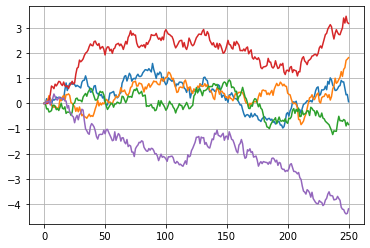

In [3]:
T,steps,d=5,250,5 #Total time, number of steps and the number of variables
time=np.linspace(0,T,steps) #Defining our time steps across the total time
t=time[1]-time[0] #Change in time
W=np.random.normal(0,np.sqrt(t),size=(steps-1,d))#brownian motion change has a mean of 0 scaled by our change in time with n-1 size as brownian motion starts at 0. standard deviation of square root t hence variance=t, mean of 0.
W=np.insert(W,0,np.zeros(d),axis=0)
B0=np.zeros((1,d)) #Array of zeros with one row and d columns
B=np.concatenate((B0,np.cumsum(W,axis=0)),axis=0) #Here we can see our Brownian motion cumulative sum and contatenate across time
plt.plot(B)
plt.grid()
plt.show()

## Starting Model parameters
These can be changed to see how the changing in paramters has an effect on the fair price

In [4]:
S=438.81 #Vanguard S&P 500 ETF current price
sigma=0.1092 #Standard Deviation
r=0.33 #Daily Treasury Yield Curve Rate
T=1 #One year simulation
M=1000 #Simulations
K=490 #This is our strike price of the call option 

Using the normal distribution to generate our brownian motion variable in the single asset case

In [5]:
def Monte_Carlo_Sample_Generation(T,M):
    return np.random.normal(0,np.sqrt(T),M)

## Geometric Brownian Motion and Stock Price formula
Under the risk neutral dynamics we assume a base observation at time 0, with a time now of $t$ on an option that matures at time $T$. We assume that the prices of our underlying stock(s) will grow through time $0\leq t \leq T$ and have: 
\begin{equation}
S_{i}(t)=S_{i}(0)e^{\sigma_{i}W_{i}(t)+(r-\frac{\sigma_{i}^2}{2})t}
\end{equation}
For an individual stock price $S_{i}(t)$ of stock $i$ at time step $t$ for stocks $S_{1},...,S_{d}$.  We require some initial values of $S_{1}(0),...,S_{d}(0)$. In the beginning stages of our problem we introduce $\textbf{W} \in \mathbb{R}^{d}$  as independant multivariate standard Brownian motion with mean $\mu = 0$ with variance $t$, $\textbf{W}$'s exponentiation in
the equation produces a GBM in stock price. To begin with we are implying that there are no correlations between stocks, however we know in practice this is not the case. 

The payoff of our option is the maximum between 0 and our simulated option profit.

In [6]:
def get_payoffs(r,S,K,T,sigma,W_T):
    Smat=S*np.exp((sigma*W_T)+(r-0.5*sigma**2)*T) #Formula (2.1) being applied to each simulation
    option_profit=Smat-K #Our options profit that is stock price at maturity minus the strike price
    payoffs=np.maximum(option_profit,0) #Finding the max between our profit and 0
    return payoffs #Returning these payoffs

## Basic Monte Carlo

The basic Monte Carlo method multiplies the mean by our discount factor $e^{-rT}$

In [7]:
def Monte_Carlo_Basic(r,T,payoffs):
    fair_price=np.mean(payoffs)*np.exp(-r*T) #Our fair price for the option is the average of the payoffs multiplied by the discount factor
    return fair_price

In [8]:
W_T=Monte_Carlo_Sample_Generation(T,M)
payoffs=get_payoffs(r,S,K,T,sigma,W_T)
fair_price=Monte_Carlo_Basic(r,T,payoffs)

In [9]:
fair_price

84.60970498965975

## Black Scholes Model

Standard Black Scholes Call formula can be used as a reference point under the single asset case

In [10]:
def Black_Scholes_Call(r,S,K,T,sigma):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    price=S*norm.cdf(d1, 0, 1) - K*np.exp(-r*T)*norm.cdf(d2, 0, 1)
    return price #Simple Black Scholes Model that returns the price

In [11]:
BS=Black_Scholes_Call(r,S,K,T,sigma)
print('We have our Black-Scholes price as {0}'.format(BS))

We have our Black-Scholes price as 86.89036811266857


## Least-Squares Monte Carlo
We can build a function that best approximates our realised valued for the payoff based on the Monte Carlo sample data and then compute the expectation of this approximation function. Then by multiplying this by our discount factor we will get our fair price as:
\begin{equation}
\hat{\Pi}=e^{-rT}\mathrm{E}[p_{\hat{c}}(\mathbf{W}(T))] 
\end{equation}
Where $p$ is our approximation function, $\mathbf{\hat{c}}$ is our vector of optimum weights and our $\mathbf{W}(T)$ are the samples of Brownian motion generated.

In [12]:
W_T=Monte_Carlo_Sample_Generation(T,M) #Our Random Variable
payoffs=get_payoffs(r,S,K,T,sigma,W_T) #Defining our Payoffs

Setting up our least-squares minimisation problem

\begin{equation}
\min_{\textbf{c}\in \mathbb{R}^{d+1}} \begin{Vmatrix} \underbrace{\begin{bmatrix}
1 & x_{1} & x_{1}^{2} & \cdots & x_{1}^{d} \\
1 & x_{2} & x_{2}^{2} & \cdots & x_{2}^{d} \\
\vdots & \vdots & & \vdots\\
1 & x_{M} & x_{M}^{2} & \cdots & x_{M}^{d} \\
\end{bmatrix}}_\textbf{:=V}  & \underbrace{\begin{bmatrix} c_{0} \\ c_{1} \\ \vdots \\ c_{d} \end{bmatrix}}_\textbf{:=c} & - &\underbrace{\begin{bmatrix} f(x_{1}) \\ f(x_{2}) \\ \vdots \\ f(x_{M}) \end{bmatrix}}_\textbf{:=f} \end{Vmatrix}
\end{equation}

In order to find the our optimum approximation function
\begin{equation}
    p_{\hat{c}}(x):=\langle \phi(x),\hat{c}\rangle=\sum^{d}_{j=0}\phi(x)_{j}\hat{c}_{j}=\hat{c}_{0} + \hat{c}_{1}x + \hat{c}_{2}x^{2} + ... + \hat{c}_{d}x^{d}
\end{equation}

In [13]:
def polynomial_basis(inputs, degree=1):
    basis_matrix = np.ones((len(inputs), 1)) #Creating an an array of ones with as many rows as samples and one column
    for counter in range(1, degree + 1):
        basis_matrix = np.c_[basis_matrix, np.power(inputs, counter)] #Adding columns to  this array with increasing powers of the corresponding row input 
    return basis_matrix

## Least-Squares General Solution
least-squares general solution for our optimum $\mathbf{\hat{c}}$:
\begin{equation}
    \mathbf{\hat{c}}=(\mathbf{V}^{T}\mathbf{V})^{-1}\mathbf{V}^{T}\mathbf{f}
\end{equation}

## Expectation through integration

By integrating between the product of the standard normal $\mathcal{N}(0, 1)$ probability density function and our approximating function $p_{\hat{c}}(x)$ between  $-\infty$ and $\infty$ our fair price becomes:
\begin{equation}
    \hat{\Pi}= \frac{e^{-rT}}{\sigma\sqrt{2\pi}}\int^{\infty}_{\infty}\sum^{d}_{j=0}\phi(x)_{j}\hat{c}_{j}\;e^{-\frac{x^{2}}{2}} dx
\end{equation}

In [14]:
def Monte_Carlo_Least_Squares_Polynomial_Int(r,T,W_T,P,payoffs):
    Matrix=polynomial_basis(W_T,P) #Putting W(T) into our basis matrix
    c=sp.linalg.lstsq(Matrix,payoffs)[0] #Finding optimum c that minimises our regression problem
    if P==1:
        fair_price=(1/np.sqrt(2*np.pi*T))*integrate.quad(lambda x: np.exp((-0.5)*(x/np.sqrt(T))**2)*(c[0]+c[1]*x),-np.inf, np.inf)[0]
    elif P==2:
        fair_price=(1/np.sqrt(2*np.pi*T))*integrate.quad(lambda x: np.exp((-0.5)*(x/np.sqrt(T))**2)*(c[0]+c[1]*x+c[2]*x**2),-np.inf, np.inf)[0] #Computing our Expectation of our function by integrating from -infinity to +infinity the pdf of the normal distribution multiplied by our polynomial function. We then multiply this by our discount factor
    else:
        print('Only valid for degrees 1 and 2')#Only able to integrate for set degree polynomials up to 2 which is limiting   
    return fair_price*np.exp(-r*T), Matrix, c

In [15]:
P=2
price_I, matrix_I, weights_I = Monte_Carlo_Least_Squares_Polynomial_Int(r,T,W_T,P,payoffs)
print('We have our Least-Squares Monte Carlo fair price after {0} simulations as {1}'.format(M,price_I))

We have our Least-Squares Monte Carlo fair price after 1000 simulations as 86.91318037238818


## Expectation through moments 

Due to the linearity of the expectation function we should be able to calculate the expectation of our function $\mathrm{E}[p_{\hat{c}}(x)]$ if we only knew the expectation of $\mathrm{E}[x^{k}]$

If $X$ has a normal distribution, the moments exist and are finite for any $k$ whose real part is greater than $-1$. For any non-negative integer $k$ then plain central moments are:
$$
\mathrm{E}[(X-\mu)^{k}]=
    \begin{cases}
      0 & \text{if } k \text{ is odd,}\\
      \sigma^{k}(k-1)!! & \text{if } k \text{ is even.}\\
    \end{cases}    
$$
Here $n!!$ denotes the \textit{double factorial}

In [16]:
from scipy.special import factorial2
def generate_cent_moments(std,degree):
   #This std variable is the standard deviation of the random variable, in our case W(T) 
    E=np.zeros(degree)
    for k in range(degree):
        if (k+1)%2!=0: #Check to see if it is odd or even
            E[k]=0
        else:
            E[k]=(std**(k+1))*factorial2(k) 
            #in the case that p is even then we apply our formula above
    return E

## Finding the fair price with moments

In [17]:
def Monte_Carlo_Least_Squares_Polynomial(r,T,W_T,P,payoffs): 
    Matrix=polynomial_basis(W_T,P) #Putting W(T) into our basis matrix
    c=sp.linalg.lstsq(Matrix,payoffs)[0] #Finding optimum c that minimises our regression problem
    E=generate_cent_moments(np.sqrt(T),P) #Generate our array of moments up to D
    fair_price=(c[0]+np.sum(c[1:]*E))*np.exp(-r*T) 
    #Our intercept plus the summation of our weights multiplied by out expectations
    return fair_price, Matrix, c 
    #Returning the fair price, the polynomial basis matrix and the optimum c

In [18]:
P=4
price, matrix, weights = Monte_Carlo_Least_Squares_Polynomial(r,T,W_T,P,payoffs)
print('We have our Least-Squares Monte Carlo using Moments fair price after {0} simulations as {1}'.format(M,price_I))

We have our Least-Squares Monte Carlo using Moments fair price after 1000 simulations as 86.91318037238818


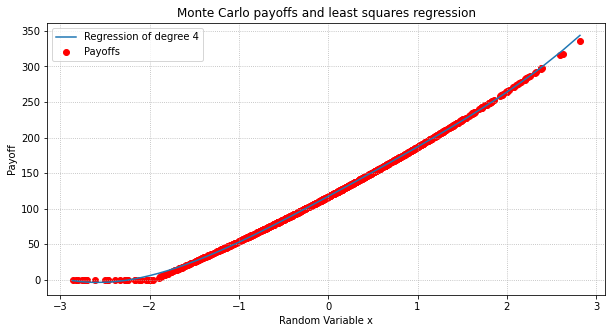

In [19]:
f=matrix@weights #Computing our function f
order=np.argsort(W_T) #Ordering values so that our graph looks nice 
W_T_ordered=W_T[order] 
f_ordered=f[order]

plt.figure(figsize=(10,5)) 
plt.scatter(W_T_ordered,payoffs[order],color='red',label='Payoffs')
plt.plot(W_T_ordered,f_ordered,label='Regression of degree '+str(P))
plt.title('Monte Carlo payoffs and least squares regression')
plt.legend()
plt.xlabel('Random Variable x') 
plt.ylabel('Payoff') 
plt.grid(True, linestyle=':') ;

## A comparison between the different methods and Black Scholes

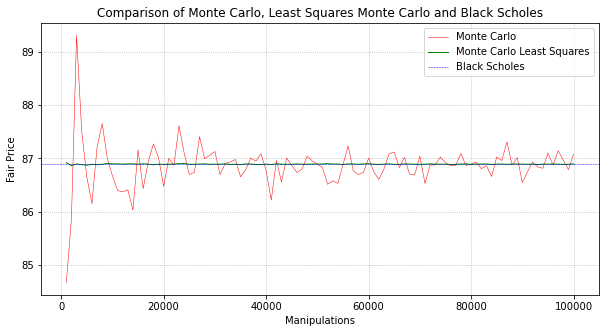

In [20]:
M_range=np.linspace(1000,100000,100).astype('int') #Arranging a set of simulations
Monte_Carlo=np.zeros(len(M_range))
Monte_Carlo_Least_Squares=np.zeros(len(M_range))
for i,m in enumerate(M_range):
    W_T=Monte_Carlo_Sample_Generation(T,m) #Our Random Variable
    payoffs=get_payoffs(r,S,K,T,sigma,W_T) #Defining our Payoffs
    Monte_Carlo[i]=Monte_Carlo_Basic(r,T,payoffs)  #Adding our standard Monte Carlo fair price for every simulation
    fair_price,_,_=Monte_Carlo_Least_Squares_Polynomial(r,T,W_T,P,payoffs) 
    Monte_Carlo_Least_Squares[i]=fair_price #Adding our Least Squares Monte Carlo fair price for every simulation
BS=Black_Scholes_Call(r,S,K,T,sigma)
plt.figure(figsize=(10,5)) 
plt.plot(M_range,Monte_Carlo,color='red',label='Monte Carlo',linewidth='0.5')
plt.plot(M_range,Monte_Carlo_Least_Squares,color='green',label='Monte Carlo Least Squares',linewidth='1')
plt.axhline(y=BS, color='b', linestyle='--', label='Black Scholes',linewidth='0.5')
plt.title('Comparison of Monte Carlo, Least Squares Monte Carlo and Black Scholes')
plt.legend()
plt.xlabel('Manipulations') 
plt.ylabel('Fair Price') 
plt.grid(True, linestyle=':') 

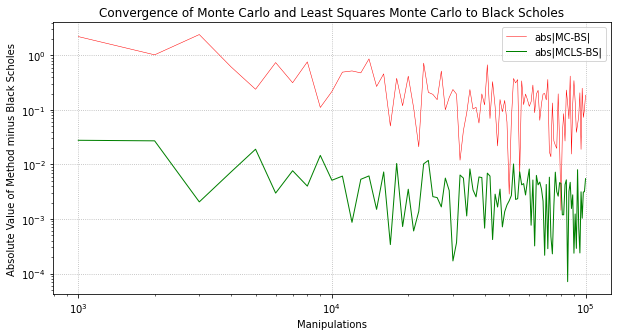

In [21]:
plt.figure(figsize=(10,5))
plt.yscale("log")
plt.xscale("log")
plt.plot(M_range,np.absolute(Monte_Carlo-BS),color='red',label='abs|MC-BS|',linewidth='0.5')
plt.plot(M_range,np.absolute(Monte_Carlo_Least_Squares-BS),color='green',label='abs|MCLS-BS|',linewidth='1')
plt.title('Convergence of Monte Carlo and Least Squares Monte Carlo to Black Scholes')
plt.legend()
plt.xlabel('Manipulations') 
plt.ylabel('Absolute Value of Method minus Black Scholes') 
plt.grid(True, linestyle=':') ;

In [22]:
P=4 #Polynomial basis dimensions
M=10000#Simulations
n=1000

## Looking at the errors of our models

In [23]:
def Error_Generator_MC_MCLS(r,S,K,T,sigma,P,M,n,MC=True,MCLS=False):
    errors=np.zeros(n) #Assign an array of n zeros 
    BS=Black_Scholes_Call(r,S,K,T,sigma) #Find the Black-Scholes price 
    for i in range(n):
        W_T=Monte_Carlo_Sample_Generation(T,M) #For each run generate our brownian motion
        payoffs=get_payoffs(r,S,K,T,sigma,W_T) #Find the associated payoffs
        if MC is True and MCLS is False: #In the case of Monte Carlo test
            errors[i]=Monte_Carlo_Basic(r,T,payoffs)-BS #Add the error for this run to the array
        elif MC is False and MCLS is True: #In the case of Least-Squares Monte Carlo test
            MCLS_Price,_,_=Monte_Carlo_Least_Squares_Polynomial(r,T,W_T,P,payoffs)
            errors[i]=MCLS_Price-BS #Add the error for this run to the array
        elif MC==MCLS:
            print('One of MC and MCLS needs to be True and the other False')
            break
    return errors #Return the array of errors

In [24]:
models=['Monte Carlo','Least-Squares Monte Carlo']
errors_MC=Error_Generator_MC_MCLS(r,S,K,T,sigma,P,M,n,True,False)
errors_MCLS=Error_Generator_MC_MCLS(r,S,K,T,sigma,P,M,n,False,True)
errors=[errors_MC,errors_MCLS]
means=np.mean(errors,axis=1)
stds=np.std(errors,axis=1)

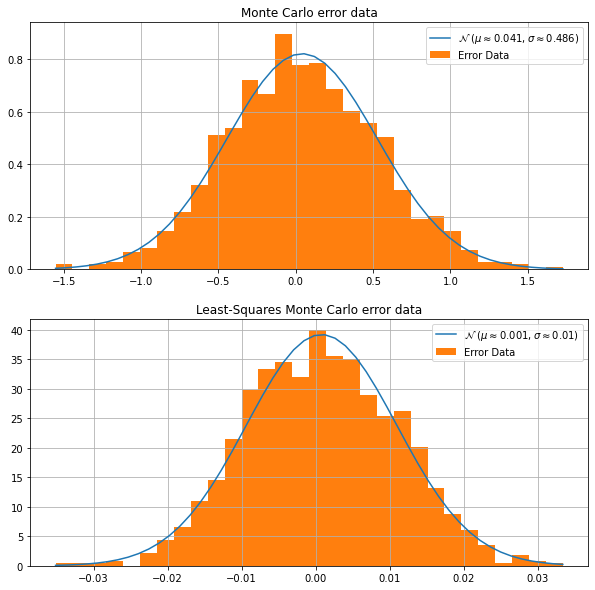

In [25]:
fig, axs = plt.subplots(2, figsize=(10, 10))
axs = axs.ravel()
for i in range(2):
    domain=np.linspace(np.min(errors[i]),np.max(errors[i]))
    axs[i].plot(domain,norm.pdf(domain,means[i],stds[i]), label='$\mathcal{N}$ '+f'$( \mu \\approx {round(means[i],3)}, \sigma \\approx {round(stds[i],3)} )$')
    #The normal distribution curve uses the a linear space from the minimum and maximum error with the mean and standard deviation of the error
    axs[i].hist(errors[i], density=1, bins=30, label='Error Data')
    #Plotting the histogram
    axs[i].set_title(models[i]+' error data')
    axs[i].grid()
    axs[i].legend()

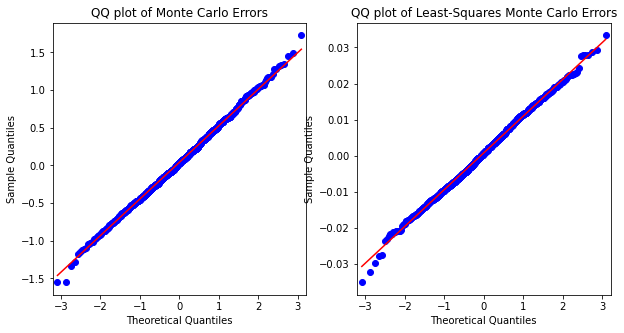

In [26]:
import statsmodels.api as sm
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 5))
sm.qqplot(errors[0], line='s',ax=ax1)
ax1.set_title('QQ plot of Monte Carlo Errors')
sm.qqplot(errors[1], line ='s',ax=ax2)
ax2.set_title('QQ plot of Least-Squares Monte Carlo Errors')
plt.show()

## Looking at the error decay of our models in relation to the number of simulations

As our errors seem to behave as a normal distribution by the central limit theorem we can expect our Monte Carlo method to display $\frac{1}{\sqrt{M}}$ convergence to our Black-Scholes price adjusted by some drift parameter.

In [27]:
from scipy.stats import t
M_range=np.linspace(10,10000,100).astype('int') #Arranging a set of simulations
Confidence_intervals=[np.zeros((len(M_range),2)),np.zeros((len(M_range),2))] #Creating a list for the confidence intervals
for i,m in enumerate(M_range):
    errors=[]
    errors.append(Error_Generator_MC_MCLS(r,S,K,T,sigma,P,m,n,MC=True,MCLS=False))
    errors.append(Error_Generator_MC_MCLS(r,S,K,T,sigma,P,m,n,MC=False,MCLS=True))
    #Generate the errors for each number of simulations
    means=np.mean(errors,axis=1)
    stds=np.std(errors,axis=1)
    for j in range(2):
        Confidence_intervals[j][i]=means[j]+(t.isf([0.975,0.025],n-1))*(stds[j]) #Add the upper and lower bound critical points

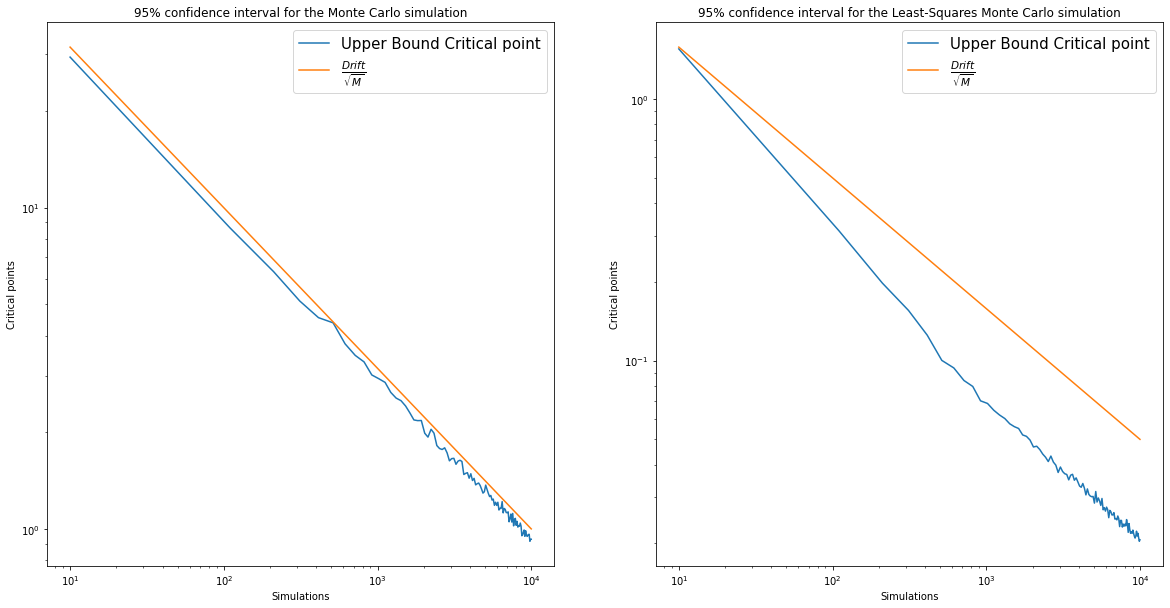

In [28]:
Drift=[100,5]
fig, axs = plt.subplots(1,2, figsize=(20, 10))
axs = axs.ravel()
for i in range(2):
    axs[i].plot(M_range,Confidence_intervals[i][:,1], label='Upper Bound Critical point')
    axs[i].plot(M_range,Drift[i]/np.sqrt(M_range), label=r'$ \frac{Drift}{\sqrt{M}}$')
    axs[i].set_yscale('log')
    axs[i].set_xscale('log')
    axs[i].set_title('95% confidence interval for the '+models[i]+' simulation')
    axs[i].set_xlabel('Simulations')
    axs[i].set_ylabel('Critical points')
    axs[i].legend(prop={"size":15})

## A look at correlation and covariance
Pulling the data from Yahoo and calculating the covariance matrix of the stock returns for the FANG companies

In [29]:
FANG=['FB','AMZN','NFLX','GOOG'] #Choosing our 4 stocks
Data={}
for stock in FANG:
    Data[stock]=pdr.data.DataReader(stock, data_source='yahoo',start=dt.datetime.today()-relativedelta(years=1)) #Importing stock data for our underlyings from the past year

dic={}
for item in FANG:
    dic[item+' Returns']=Data[item]['Adj Close'].pct_change() #Calculates the returns for each stock

Returns=pd.DataFrame(dic) #Creating the data frame
Returns_Covariance=Returns.cov().to_numpy() #Creating an array for the covariance matrix

## Cholesky Decomposition
We use the Cholesky decomposition to decompose a positive definite matrix into the the product of a lower triangular matrix and its transpose
$$
\mathbf{A}= \mathbf{L}\cdot \mathbf{L}^{T}
=
\left( \begin{matrix}
L_{11} & 0 & 0 \\
L_{21} & L_{22} & 0 \\
L_{31} & L_{32} & L_{33}\\
\end{matrix} \right)
\left( \begin{matrix}
L_{11} & L_{12} & L_{13} \\
0 & L_{22} & L_{23} \\
0 & 0 & L_{33}\\
\end{matrix} \right)
$$
By using this we can generate correlated random variables by multiplying the lower triangular from decomposing the covariance matrix by standard normals.

In [30]:
def Correlated_Sample_Generator(cov_matrix,T,d,M):
    return np.linalg.cholesky(cov_matrix)@np.random.normal(0,np.sqrt(T),(d,M)) 

## Monte Carlo Basket Pricing
Starting by generating brownian motion for multiple assets

In [31]:
def Monte_Carlo_Sample_Generation_Higher(T,M,d):
    return np.random.normal(0,np.sqrt(T),(M,d))

In general we aim to get our optimum fair price $\hat{\Pi}$  that approximates the true fair price $\Pi$.
\begin{equation}
    \hat{\Pi}=e^{-rT}\frac{1}{M}\sum^{M}_{m=1}\max\left\{0,\sum^{d}_{i=1}\omega_{i}S_{i}(0)\exp\left\{\sigma_{i}\hat{W}^{m}_{i}(T)+(r-\frac{\sigma_{i}^{2}}{2})T\right\}-K\right\}
\end{equation}
We can introduce our vector of weights as $ \pmb{\omega}=(\omega_{1},...,\omega_{d})\in \mathbb{R}^{d} $. The basket is then defined as the weighted arithmetic average of the $d$ stock prices.

In [32]:
def get_payoffs_basket(r,S,K,T,sigma,W_T,M,d,w):
    if np.sum(w)==1: #We require the weighted average to add up to 1
        Smat=np.zeros((d,M)) #Starting our final S as a vector of zeros shape d x M
        for i in range(d):
                Smat[i]=w[i]*S[i]*np.exp((sigma[i]*W_T[:,i])+(r-0.5*sigma[i]**2)*T) 
                #For each underlying stock we apply our stock price formula
        S_basket_prices=Smat.sum(axis=0) #Our basket price is the sum of the weighted stock prices
        option_profit=S_basket_prices-K #Our options profit will be the stock price at maturity minus the strike price
        payoffs=np.maximum(option_profit,0) #The option will only be exercised if in profit 
        return payoffs
    else:
        print('Weighted average must sum to 1') #In the case the weighted average does not add to 1 we print an error message

## Monomial Basis
In order to define our monomial basis for degree $P$ we let $\alpha = (\alpha_{1},...,\alpha_{d})$ be a multi-index with components $\alpha \in \{0,1,...,P\}$ for every $i=1,...,d$. Then we can define our monomial functions as the following monomial example:
\begin{equation}
    \phi_{\alpha}:=\mathbf{x}^{\alpha}=x^{\alpha_{1}}_{1}*x^{\alpha_{2}}_{2}*...x^{\alpha_{d}}_{d}
\end{equation}
Now, for our monomial basis up to degree $P$ we will need to generate our multi-indices that allows for every possible combination of $d$ numbers that sums to $P$ i.e $\sum^{d}_{i=1}\alpha_{i}=P$. We will then take these sets of combinations and permutate them into all possible unique layouts.

In [33]:
def generate_multindex(degree,dimensions):
    def finding_sums(input_numbers, target, partial=[], partial_sum=0): #This function is used to find all possible combinations of the variable numbers that equal the target
        if partial_sum == target:
            yield partial #If the partial_sum is equal to our target then we have succeeded and we yield the partial 
        if partial_sum >= target:
            return #If not we return nothing
        for i, num in enumerate(input_numbers):
            remaining = input_numbers[i:] #Allowing all elements from i onwards to be used in the next recursion
            yield from finding_sums(remaining, target, partial + [num], partial_sum + num) #Using a recursion to go all the way down to all 1's and then back up and changing the partial
    sums=list(finding_sums(np.arange(1,degree+1),degree)) #Turn our sums into a list
    multi_index=np.zeros((len(sums),dimensions)) #We will create an array of zeros with as many columns as we have dimensions
    for i in range(len(sums)):
        if len(sums[i])<=dimensions: #We want all the sums that have elements less than or equal to the dimensions
            for j in range(len(sums[i])):
                multi_index[i,j]=sums[i][j] #Updating our multi_index array
    indexes=multi_index[~np.all(multi_index==0,axis=1)] #Removing all zero rows
    permutated_multindex=np.array([]) #Create an empty array
    for index in indexes:
        for permutation in multiset_permutations(index):
            permutated_multindex=np.append(permutated_multindex,np.array(permutation)) #We use a package from SymPy to find all the possible unique permutations of our indexes
    return permutated_multindex.reshape((-1,dimensions)).astype('int') #Output our Multindices in one array


In [34]:
generate_multindex(4,3)

array([[1, 1, 2],
       [1, 2, 1],
       [2, 1, 1],
       [0, 1, 3],
       [0, 3, 1],
       [1, 0, 3],
       [1, 3, 0],
       [3, 0, 1],
       [3, 1, 0],
       [0, 2, 2],
       [2, 0, 2],
       [2, 2, 0],
       [0, 0, 4],
       [0, 4, 0],
       [4, 0, 0]])

## Monomial Basis Least-Squares Problem
We can now build our monomial basis matrix and fit it to our Least-Squares problem:
\begin{equation}
\min_{\textbf{c}\in \mathbb{R}^{d+1}} \begin{Vmatrix} \underbrace{\begin{bmatrix}
1 & \phi_{1}(\mathbf{x}_{1}) & \phi_{2}(\mathbf{x}_{1})& \cdots & \phi_{b}(\mathbf{x}_{1}) \\
1 & \phi_{1}(\mathbf{x}_{2}) & \phi_{2}(\mathbf{x}_{2}) & \cdots & \phi_{b}(\mathbf{x}_{2}) \\
\vdots & \vdots & & \vdots\\
1 & \phi_{1}(\mathbf{x}_{M}) & \phi_{2}(\mathbf{x}_{M}) & \cdots & \phi_{b}(\mathbf{x}_{M}) \\
\end{bmatrix}}_\textbf{:=V}  & \underbrace{\begin{bmatrix} c_{0} \\ c_{1} \\ \vdots \\ c_{b} \end{bmatrix}}_\textbf{:=c} & - &\underbrace{\begin{bmatrix} f(\mathbf{x}_{1}) \\ f(\mathbf{x}_{2}) \\ \vdots \\ f(\mathbf{x}_{M}) \end{bmatrix}}_\textbf{:=f} \end{Vmatrix} 
\end{equation}
With the goal of finding the optimum coefficient vector $\hat{c}$ that best approximates our realised values $f(\mathbf{x_{i}})$ such that it minimises $\min_{\textbf{c}\in \mathbb{R}^{d+1}}||\mathbf{Vc}-\mathbf{f}||$. To produce a function $p_{\hat{c}}(\mathbf{x})$ such that
\begin{equation}
    f(\mathbf{x})\approx p_{\hat{c}}(\mathbf{x}):=\hat{c}_{0}+\sum^{n}_{j=1}\hat{c}_{j}\phi_{j}(\mathbf{x})
\end{equation}
which is an approximation of $f$ at all points $\mathbf{x} \in \mathbb{R}^{d}$.

In [35]:
def monomial_basis(inputs, degree=1, dimensions=1):
    basis_matrix = np.ones((len(inputs), 1)) #Creating a basis_matrix with as many rows as inputs and a 1 in the first column
    psi=generate_multindex(1,dimensions) #Generate all the possible indexes for degree 1
    for i in range(2,degree+1):
        psi=np.vstack((psi,generate_multindex(i,dimensions))) #Vertically stack onto our psi array the multindex for all degrees up to our intended degree
    for index in psi:
        basis_matrix=np.c_[basis_matrix,np.product(np.power(inputs,index),axis=1)] #For each manipulations set of brownian motion we apply the multindezs components in the form of a monomial
    return basis_matrix, psi #Finally returning the basis_matrix and the important psi

## Higher Moments for Expectation
We use Isserlis' Theorem to calculate the required higher order moments.

If $(X_{1},...,X_{d})$ is a zero-mean multivariate normal random vector then under the even case $d=2m$
$$\mathrm{E}[X_{1}X_{2}\cdots X_{2m}]=\sum\prod \mathrm{E}[X_{i}X_{j}]=\sum\prod\Cov(X_{i}X_{j})$$ and the odd case $d=2m+1$
$$\mathrm{E}[X_{1}X_{2}\cdots X_{2m+1}] = 0$$
\end{theorem}
where the notation $\sum\prod$ means summing over all distinct ways of partitioning $(X_{1},...,X_{2m})$ into pairs. That is, the $2m$ variables are partioned into cells containing pairs of the variables. The expected values $\mathrm{E}[X_{i}X_{j}]$ are formed for the products of the pairs in each cell and these expected values are multiplied together for all $m$ cells. These products are then summed for all partitions into cells which are distinct, that is, the ordering of the cells and of the pairs within the cells are not distinguished.

In [36]:
def pairing(inputs):
    return zip(*([iter(inputs)] * 2)) #By using a zip we can group the data into chronological pairs

def partitioning(input_numbers, n=2):
    set_partitions = set() #Define an empty set
    for permutation in it.permutations(input_numbers): #We use the permutation function from the itertools package to loop over all possible permutations of an iterable sequence
        grouped = pairing(list(permutation)) #We group the permutations into pairs
        sorted_group = tuple(sorted([tuple(sorted(partition)) for partition in grouped])) #Sort the items in the individual pair and then sort all the pairs
        set_partitions.add(sorted_group) #Add to our set, by using a set we get only the unique items
    return set_partitions

In [37]:
partitioning(range(2))

{((0, 1),)}

In [38]:
partitioning(range(4))

{((0, 1), (2, 3)), ((0, 2), (1, 3)), ((0, 3), (1, 2))}

In [39]:
partitioning(range(6))

{((0, 1), (2, 3), (4, 5)),
 ((0, 1), (2, 4), (3, 5)),
 ((0, 1), (2, 5), (3, 4)),
 ((0, 2), (1, 3), (4, 5)),
 ((0, 2), (1, 4), (3, 5)),
 ((0, 2), (1, 5), (3, 4)),
 ((0, 3), (1, 2), (4, 5)),
 ((0, 3), (1, 4), (2, 5)),
 ((0, 3), (1, 5), (2, 4)),
 ((0, 4), (1, 2), (3, 5)),
 ((0, 4), (1, 3), (2, 5)),
 ((0, 4), (1, 5), (2, 3)),
 ((0, 5), (1, 2), (3, 4)),
 ((0, 5), (1, 3), (2, 4)),
 ((0, 5), (1, 4), (2, 3))}

In [40]:
def ordering_of_Xs(alpha):
    ordering=np.array([]) #Create an empty array
    for i,alph in enumerate(alpha):
        ordering=np.append(ordering,i*np.ones(alph)) #Add to the array a sequence of indexes for however many is stated in the multiindex intended to be used as the slice for the covariance matrix
    return ordering.astype('int')

def generate_higher_moments(covariance_matrix,psi):
    E=np.zeros(len(psi)) #We will have the same number of moments as we have number of psi functions
    for i,alpha in enumerate(psi): #Loop across all psi functions
        k=sum(alpha) #The sum of the multiindex is the order of the moment
        if k%2!=0: #Check to see if it is odd
            E[i]=0 #If the order is odd then the moment is 0
        if k==2: #If the order is two we can do a simple calculation
            ordering=ordering_of_Xs(alpha) #Find the correct ordering of alpha
            E[i]=covariance_matrix[ordering[0],ordering[1]] #The second order moment is just the covariance of the two variables
        if k%2==0 and k!=2: #If the order of the moment is even and not equal to two
            partitions=partitioning(range(k)) #We find all the partition pairs
            ordering=ordering_of_Xs(alpha) #Find the ordering of the Xs
            sum_run=0 #Initiate a sum at 0
            for partition in partitions:
                prod_run=1 #Initiate a product at 1
                for pair in partition:
                    prod_run*=covariance_matrix[ordering[pair[0]],ordering[pair[1]]] #We multiply all pairs covariances together
                sum_run+=prod_run #We sum for every covariance product for every partition 
            E[i]=sum_run #The moment becomes this sum
    return E

In [41]:
r=0.01 #Interest rate
sig_a, sig_b=0.15,0.3 #Annual volatility for each underlying
sigma=[sig_a,sig_b] 
d=2 #Dimensions i.e number of stocks
S_a,S_b=50,60 #Initial stock prices
S=[S_a,S_b] #List of the starting stock prices
T=1 #1 year
M=1000 #Simulations
K=55 #Strike Price
w=[0.5,0.5]
P=5

In [42]:
W_T=Monte_Carlo_Sample_Generation_Higher(T,M,d)
payoffs=get_payoffs_basket(r,S,K,T,sigma,W_T,M,d,w)
X, psi=monomial_basis(W_T,P,d)
c=sp.linalg.lstsq(X,payoffs)[0]

## 3D plot of a 2 dimensional basket case

In [43]:
x,y = W_T[:,0],W_T[:,1]
x_values, y_values = np.linspace(np.min(x),np.max(x),10), np.linspace(np.min(y),np.max(y),10)
x1,x2=np.meshgrid(x_values,y_values)

def my_function(x,y,psi,c):
    return np.sum(c[1:]*((x**psi[:,0])*(y**psi[:,1])))

def creating_z(X,Y,psi,c):
    Z=np.zeros((X.shape))
    for i in range(len(X)):
        for j in range(len(X)):
            Z[i,j]=my_function(X[i,j],Y[i,j],psi,c)
    return Z
    
Z=creating_z(x1,x2,psi,c)

In [44]:
%matplotlib notebook

<IPython.core.display.Javascript object>


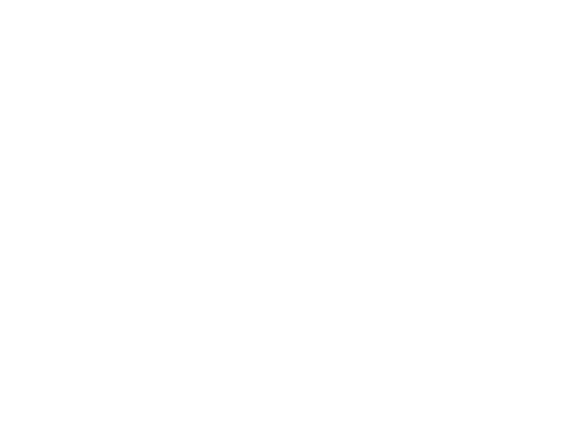

In [45]:
ax = plt.axes(projection='3d')
ax.plot_wireframe(x1,x2,Z, label='Approximate Function')
ax.scatter3D(x,y,payoffs,c ='red',label='Realised Value Payoffs')
ax.legend();

In [46]:
%matplotlib inline

## Least-Squares Monte Carlo Basket Pricing

Putting together all of the functions we have made together we can build up our function to calculate the fair price of a basket call option of $d$ underlying assets up to a chosen degree $P$.

In [47]:
def Monte_Carlo_Least_Squares_Monomial_Higher_Moments(r,T,W_T,P,payoffs,d): 
    X, psi=monomial_basis(W_T,P,d) #Putting the brownian motion into our basis matrix and also outputting the psi functions
    c=sp.linalg.lstsq(X,payoffs)[0] #Finding optimum c that minimises our regression problem
    E=generate_higher_moments(np.cov(W_T.T),psi) #Generate our array of higher moments for every psi function
    fair_price=(c[0]+np.sum(c[1:]*E))*np.exp(-r*T) #Our intercept plus the summation of our weights multiplied by our expectations
    return fair_price #Returning our expectation multplied by our discount factor which is our fair price

## Comparison of Basket Case Models

In [48]:
r=0.1 #Interest rate
S_a,S_b,S_c,S_d=50,60,70,80 #Initial stock prices
S=[S_a,S_b,S_c,S_d] #List of the starting stock prices
K=65 #Strike Price
T=1 #1 year
sig_a, sig_b, sig_c, sig_d=0.15,0.3,0.6,0.2 #Annual volatility for each underlying
sigma=[sig_a,sig_b,sig_c,sig_d] 
M=10000 #Simulations
d=4 #Dimensions i.e number of stocks
P=7
w=[0.4,0.25,0.25,0.1]

In [49]:
M_range=np.linspace(1000,100000,100).astype('int')#Arranging a set of simulations
Monte_Carlo=np.zeros(len(M_range))
Monte_Carlo_Least_Squares=np.zeros(len(M_range))
for i,m in enumerate(M_range):
    W_T=Monte_Carlo_Sample_Generation_Higher(T,m,d) #Our Random Variable
    payoffs=get_payoffs_basket(r,S,K,T,sigma,W_T,m,d,w) #Defining our Payoffs
    Monte_Carlo[i]=Monte_Carlo_Basic(r,T,payoffs) #Adding our standard Monte Carlo fair price for every simulation
    Monte_Carlo_Least_Squares[i]=Monte_Carlo_Least_Squares_Monomial_Higher_Moments(r,T,W_T,P,payoffs,d) #Adding our Least Squares Monte Carlo fair price for every simulation

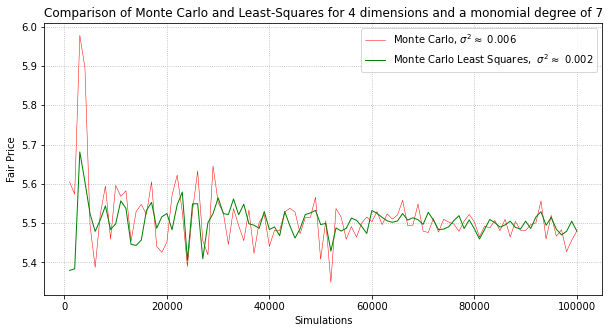

In [50]:
plt.figure(figsize=(10,5)) 
plt.plot(M_range,Monte_Carlo,color='red',label=f'Monte Carlo, $\sigma^{{2}} \\approx$ {round(np.var(Monte_Carlo),3)}',linewidth='0.5')
plt.plot(M_range,Monte_Carlo_Least_Squares,color='green',label=f'Monte Carlo Least Squares,  $\sigma^{{2}} \\approx$ {round(np.var(Monte_Carlo_Least_Squares),3)}',linewidth='1')
plt.title(f'Comparison of Monte Carlo and Least-Squares for 4 dimensions and a monomial degree of {P}')
plt.legend()
plt.xlabel('Simulations') 
plt.ylabel('Fair Price') 
plt.grid(True, linestyle=':') ;